<a href="https://colab.research.google.com/github/nethmi-monali/DL_Lab06/blob/main/SLIIT_SE4050_MPGNN_2024_July_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Message Passing Graph Neural Networks

We develop a simplified version of orginal GNN models that were proposed by Merkwirth and Lengauer [2005] and Scarselli et al. [2009]. We develop custom MPGNN layers and FFNN layers so that students can understand what is happening under the hood in GNNs. We use the standard model training pipeline ( inlcuding optimization) since those were covered in detail in early lectures. For this purpose we use Cora dataset, which is a citation dataset and the task is a node classification. Deep graph Library (DGL) is only used to load the dataset. NetworkX is used for visualizations. <br>
Since PyTroch framework is used for model builting students should be familiar with the model bulding pipeline in that framework. Refer this [PyTorch tutorial](https://pytorch.org/tutorials/beginner/introyt/trainingyt.html) to get a basic idea about it.
Students should read about the dataset before running this code to get an idea about the data as well. Refer the [lecture slides](https://drive.google.com/file/d/13cpiZT3qzJDxdYXan7sKtcUAD2oxtVUF/view?usp=sharing) [specifically pages 35 -52 ] to understand the MPGNN model and the equations. Students are also encouraged to experiment with this code.<br>
<br>





In [1]:
!pip install torch==2.3.0 torchvision==0.18.0 torchaudio==2.3.0 --index-url https://download.pytorch.org/whl/cu121

Looking in indexes: https://download.pytorch.org/whl/cu121
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.0/781.0 MB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 77.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 75.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 53.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 53.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 30.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1

In [2]:
!pip install  dgl -f https://data.dgl.ai/wheels/torch-2.3/cu121/repo.html

Looking in links: https://data.dgl.ai/wheels/torch-2.3/cu121/repo.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 355.1/355.1 MB 4.0 MB/s eta 0:00:00


In [3]:
import dgl
import numpy as np
import torch
import pdb
import torch.nn.init as init
import matplotlib.pyplot as plt
import time
from sklearn.metrics import confusion_matrix
import networkx as nx

DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


In [4]:
torch.__version__

'2.3.0+cu121'

In [5]:
torch.Tensor(2,2)

tensor([[1.1193e-15, 4.4469e-41],
        [1.1193e-15, 4.4469e-41]])

In [6]:
# Load the Cora dataset
dataset = dgl.data.CoraGraphDataset()

# Get the graph, features, and labels
g = dataset[0]  # The graph itself
features = g.ndata['feat']  # Node features
labels = g.ndata['label']  # Node labels

print(f'Number of categories: {dataset.num_classes}')
print(f'Node features shape: {features.shape}')
print(f'Label shape: {labels.shape}')
print(f'object type: {type(g)}')

/root/.dgl/cora_v2.zip:   0%|          | 0.00/132k [00:00<?, ?B/s]

Extracting file to /root/.dgl/cora_v2_d697a464
Finished data loading and preprocessing.
  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done saving data into cached files.
Number of categories: 7
Node features shape: torch.Size([2708, 1433])
Label shape: torch.Size([2708])
object type: <class 'dgl.heterograph.DGLGraph'>


In [7]:
g.edges()[1]

tensor([ 633, 1862, 2582,  ...,  598, 1473, 2706])

In [8]:
type(dataset)
features.shape
new_arr_0 = features[0,:].numpy()[np.where(features[0,:].numpy()!=0)]
print(new_arr_0)

[0.11111111 0.11111111 0.11111111 0.11111111 0.11111111 0.11111111
 0.11111111 0.11111111 0.11111111]


In [9]:
# get data split
train_mask = g.ndata['train_mask']
val_mask = g.ndata['val_mask']
test_mask = g.ndata['test_mask']

In [10]:
val_mask

tensor([False, False, False,  ..., False, False, False])

In [11]:
val_mask.numpy()[val_mask.numpy()==True].shape

(500,)

In [12]:
val_mask

tensor([False, False, False,  ..., False, False, False])

In [13]:
print(type(features))
print(labels.unsqueeze(-1).shape)
print(labels.unsqueeze(-1).dtype)
print(torch.ones(1433).unsqueeze(0).dtype)
labels.unsqueeze(-1)[:8]

<class 'torch.Tensor'>
torch.Size([2708, 1])
torch.int64
torch.float32


tensor([[3],
        [4],
        [4],
        [0],
        [3],
        [2],
        [0],
        [3]])

In [14]:
#create a features tensor - Not used in the main code atm
struc_features = torch.matmul((torch.ones(2708)*0.1).unsqueeze(-1), torch.ones(1433).unsqueeze(0))
print(struc_features.shape)
print(struc_features[:8,:])

torch.Size([2708, 1433])
tensor([[0.1000, 0.1000, 0.1000,  ..., 0.1000, 0.1000, 0.1000],
        [0.1000, 0.1000, 0.1000,  ..., 0.1000, 0.1000, 0.1000],
        [0.1000, 0.1000, 0.1000,  ..., 0.1000, 0.1000, 0.1000],
        ...,
        [0.1000, 0.1000, 0.1000,  ..., 0.1000, 0.1000, 0.1000],
        [0.1000, 0.1000, 0.1000,  ..., 0.1000, 0.1000, 0.1000],
        [0.1000, 0.1000, 0.1000,  ..., 0.1000, 0.1000, 0.1000]])


In [15]:
#create a features tensor - Not used in the main code atm
struc_features_1 = torch.matmul((labels*0.1).unsqueeze(-1).to(dtype=torch.float32), torch.ones(1433).unsqueeze(0))
print(struc_features_1.shape)
print(struc_features_1[:8,:])

torch.Size([2708, 1433])
tensor([[0.3000, 0.3000, 0.3000,  ..., 0.3000, 0.3000, 0.3000],
        [0.4000, 0.4000, 0.4000,  ..., 0.4000, 0.4000, 0.4000],
        [0.4000, 0.4000, 0.4000,  ..., 0.4000, 0.4000, 0.4000],
        ...,
        [0.2000, 0.2000, 0.2000,  ..., 0.2000, 0.2000, 0.2000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.3000, 0.3000, 0.3000,  ..., 0.3000, 0.3000, 0.3000]])


In [16]:
g.edges() # original edges are in an edge list as set of directed edges

(tensor([   0,    0,    0,  ..., 2707, 2707, 2707]),
 tensor([ 633, 1862, 2582,  ...,  598, 1473, 2706]))

In [17]:
# create the adjacency matrix
num_nodes = len(g.nodes())
print(num_nodes)
adj = np.zeros((num_nodes, num_nodes))
print(adj.shape)
for i in range(len(g.edges()[0])):
  # print(i)
  row = g.edges()[0][i]
  col = g.edges()[1][i]

  adj[row, col] = 1
  adj[col, row] = 1

adj_torch = torch.from_numpy(adj)# use in model development
adj_torch = adj_torch.to(dtype=torch.float32)
print(adj_torch.shape)
print(adj_torch.dtype)
print((adj.T - adj).sum()) # symmetric as it should be

2708
(2708, 2708)
torch.Size([2708, 2708])
torch.float32
0.0


In [18]:
# Get the adjacency matrix in dense format
adj_matrix_dense = g.adjacency_matrix().to_dense()

# Get the adjacency matrix in sparse format
adj_matrix_sparse = g.adjacency_matrix()

print("Dense adjacency matrix:\n", adj_matrix_dense)
print("Dense adjacency matrix:\n", adj_matrix_dense.shape)
print("Sparse adjacency matrix:\n", adj_matrix_sparse)
print("Sparse adjacency matrix:\n", adj_matrix_sparse.shape)

Dense adjacency matrix:
 tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 1., 0.]])
Dense adjacency matrix:
 torch.Size([2708, 2708])
Sparse adjacency matrix:
 SparseMatrix(indices=tensor([[   0,    0,    0,  ..., 2707, 2707, 2707],
                             [ 633, 1862, 2582,  ...,  598, 1473, 2706]]),
             values=tensor([1., 1., 1.,  ..., 1., 1., 1.]),
             shape=(2708, 2708), nnz=10556)
Sparse adjacency matrix:
 (2708, 2708)


In [19]:
# undirected graph it seems
print(np.abs(adj).sum())
print(adj.sum())
# no self loops
print(np.trace(np.abs(adj)))

10556.0
10556.0
0.0


In [20]:
print(features[train_mask].shape)
print(labels[train_mask].shape)
labels[train_mask]
tmp = list(features[train_mask][10].numpy())
my_list = [x for x in tmp if x != 0]
print(my_list) # thus feature matrix is normalized row wise
print(len(my_list))

torch.Size([140, 1433])
torch.Size([140])
[0.05882353, 0.05882353, 0.05882353, 0.05882353, 0.05882353, 0.05882353, 0.05882353, 0.05882353, 0.05882353, 0.05882353, 0.05882353, 0.05882353, 0.05882353, 0.05882353, 0.05882353, 0.05882353, 0.05882353]
17


## Visualize the CORA dataset

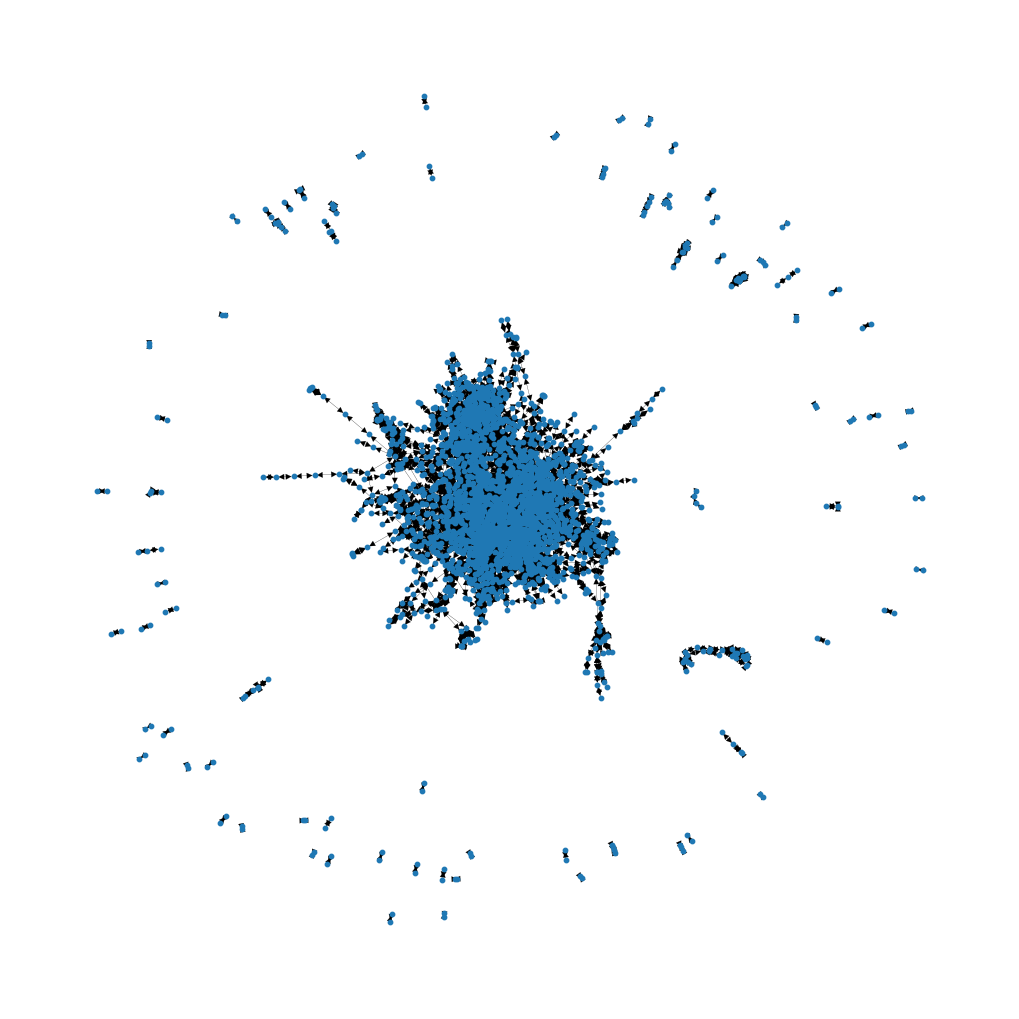

In [21]:
#visualize the entire dataset

# Convert the DGL graph to a NetworkX graph
nx_g = g.to_networkx()

plt.figure(figsize=(10, 10))
pos = nx.spring_layout(nx_g, seed=42)  # Use spring layout
nx.draw(nx_g, pos, node_size=10, width=0.1, with_labels=False)
plt.show()


In [ ]:
#visualize the dataset with labels - each node belong to a class out of 7 classes so 7 colours are used
color_map = [
    'red', 'green', 'blue', 'yellow', 'purple', 'orange', 'cyan'
]

colors = [color_map[label] for label in labels]
nx_g = g.to_networkx()

plt.figure(figsize=(10, 10))
pos = nx.spring_layout(nx_g, seed=42)
nx.draw(nx_g, pos, node_color=colors, node_size=10, width=0.1, with_labels=False)
plt.title("Graph Visualization with Node Labels")
plt.show()

In [ ]:
#same as before but more detailed - open the image in a new tab for higher resolution
plt.figure(figsize=(40, 40))
nx.draw(nx_g, pos, node_color=colors, node_size=12, width=0.4, with_labels=False, arrows=False)
plt.title("Graph Visualization with Node Labels")
plt.show()

In [ ]:
# visualize using circular layout - less time to visualize
plt.figure(figsize=(10, 10))
pos = nx.circular_layout(nx_g)
nx.draw(nx_g, pos, node_size=10, width=0.1, with_labels=False)
plt.show()

In [ ]:
# visualize graph with each train/ validation / test split using circular layout

# train set in red, validation in green and test is in blue
colors = np.where(train_mask, 'red', np.where(val_mask, 'green', 'blue'))
plt.figure(figsize=(10, 10))
nx.draw(nx_g, pos, node_color=colors, node_size=10, width=0.1, with_labels=False)
plt.title("Graph Visualization with Train/Val/Test Nodes")
plt.show()

## MPGNN Architecture

Refer the equations of the MPGNN in the lecture slides.

In [ ]:
# Individual MPGNN layer is built from scratch
class MPGNN_Layer(torch.nn.Module):

    def __init__(self, input_embed_size =-1, output_embed_size = -1, bias_ = True):
        super(MPGNN_Layer, self).__init__()


        self.input_size = input_embed_size
        self.output_size = output_embed_size
        self.bias_ = bias_

        self.adj_M = adj_torch
        # print(self.adj_M.dtype)
        self.relu = torch.nn.ReLU()
        self.ones_v = torch.ones(num_nodes).unsqueeze(-1)

        self.weights_self = torch.nn.Parameter(torch.Tensor(input_embed_size , output_embed_size))
        self.weights_neigh = torch.nn.Parameter(torch.Tensor(input_embed_size , output_embed_size))

        self.initialize_parameters()

        if self.bias_ :
          self.bias = torch.nn.Parameter(torch.zeros(1, output_embed_size))


    def forward(self, x): # x should be embedding matrix of graph, shape -> (num_nodes, embed_length)

        num_nodes = x.shape[0]

        #msg passing
        msg_neigh = torch.matmul(x ,self.weights_neigh)
        # aggregation
        aggreg_neigh = torch.matmul(self.adj_M, msg_neigh)
        # update
        tmp_emb = aggreg_neigh +  torch.matmul(x ,self.weights_self)

        # pdb.set_trace()
        # non-linear activation and bias adding
        if self.bias_ :
          self.bias_matrix = torch.matmul(self.ones_v , self.bias)
          linear_out = tmp_emb + self.bias_matrix
          output_emb = self.relu(linear_out)
        else:
          output_emb = self.relu(tmp_emb)

        return output_emb

    def initialize_parameters(self):
        # Xavier initialization for weights
        init.xavier_uniform_(self.weights_self)
        init.xavier_uniform_(self.weights_neigh)


In [ ]:
#FFNN layer is built from scratch
class FC_scratch(torch.nn.Module):
    def __init__(self, input_feat_num =-1,  output_feat_num=-1, activation = None):
        super(FC_scratch, self).__init__()

        self.act = activation
        self.ones_v = torch.ones(num_nodes).unsqueeze(-1)

        self.weights_FC = torch.nn.Parameter(torch.Tensor(input_feat_num , output_feat_num))
        self.bias = torch.nn.Parameter(torch.Tensor(1, output_feat_num))

        self.initialize_parameters()

    def forward(self, x):

        bias_matrix = torch.matmul(self.ones_v , self.bias)
        x = torch.matmul(x , self.weights_FC) + bias_matrix

        if self.act != None:
          return self.act(x)
        else:
          return x # needed  when we only need linear outputs

    def initialize_parameters(self):
        init.xavier_uniform_(self.weights_FC)
        init.xavier_uniform_(self.bias)

In [ ]:
# MPGNN Complete model is built from scratch
class MPGNN_Model(torch.nn.Module):

    def __init__(self, input_feat_num =1433,  num_classes=7):
        super(MPGNN_Model, self).__init__()

        self.softmax = torch.nn.Softmax()

        self.MPGNN_1 = MPGNN_Layer(input_feat_num, 512)
        self.MPGNN_2 = MPGNN_Layer(512, 64)
        # self.fc = torch.nn.Linear(64, num_classes)
        self.fc = FC_scratch(64 , num_classes)



    def forward(self, x): # x should be feature matrix of graph, shape -> (num_nodes, feature_length)

        hid_1 = self.MPGNN_1(x)
        hid_2 = self.MPGNN_2(hid_1)

        #classification
        tmp_out = self.fc(hid_2)
        final_out = self.softmax(tmp_out)

        return final_out


In [ ]:
#create an instance of the model and optimizer + loss function; currently not using a lr schedular
model = MPGNN_Model()
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [ ]:
# Model parameters are calculated here
trainable_params = []
non_trainable_params = []

for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"Trainable parameter: {name} - size: {param.size()}")
        trainable_params.append(param)
    else:
        print(f"Non-trainable parameter: {name} - size: {param.size()}")
        non_trainable_params.append(param)

# Calculate the total number of trainable and non-trainable parameters
num_trainable_params = sum(p.numel() for p in trainable_params) # numel()  returns the total number of elements in a tensor
num_non_trainable_params = sum(p.numel() for p in non_trainable_params)

print(f"Number of trainable parameters: {num_trainable_params}")
print(f"Number of non-trainable parameters: {num_non_trainable_params}")

In [ ]:
print(features.shape)
print(labels.shape)
print(labels[train_mask].shape[0])

In [ ]:
# train step function is defined here - since full batch is used in forward pass, this step is actually epoch wise rather than batch wise

running_loss =[]
running_acc = []

def train_one_epoch(epoch_index, features, labels, tb_writer = None):

    inputs = features
    labels = labels


    # Zero the gradients at each start epoch
    optimizer.zero_grad()

    # Make predictions for the entire graph nodes
    outputs = model(inputs)

    # Compute the loss for training subgraph
    outputs_train = outputs[train_mask]
    labels_train = labels[train_mask]

    loss = loss_fn(outputs_train, labels_train)

    # backpropagation and update weights
    loss.backward()
    optimizer.step()

    # Gather data and print
    total = labels_train.shape[0]
    loss_per_node = loss
    print(f'Train Loss: {loss_per_node}')
    running_loss.append(loss_per_node)


    max_prob , max_prob_index = torch.max(outputs_train, dim=1)
    if epoch_index % 100 == 0:
      print('max_prob_index: ', max_prob_index)
      print('max_prob_values: ', max_prob)

    # Compare predictions to ground truth
    correct = (max_prob_index == labels_train).sum().item()
    # Calculate accuracy
    accuracy = correct / total
    print(f'Train Accuracy: {accuracy * 100:.2f}%')
    running_acc.append(accuracy)

    return loss_per_node, accuracy

## Standard Model Training

In [ ]:
# set the input feature matrix for the training / validation / test

# features = struc_features #use this if structural information is only used
features = features # use this if {feature + strutural} informationn is use

In [ ]:
# model training is done here

EPOCHS = 500
val_running_loss = []
val_running_acc = []

start_time = time.time()

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch + 1))

    model.train(True)
    avg_loss, avg_acc = train_one_epoch(epoch, features, labels, None) # training


    # Set the model to evaluation mode, disabling dropout etc.
    model.eval()

    # validation of the model on val dataset
    with torch.no_grad():

      outputs = model(features) #validation

      outputs_val = outputs[val_mask]
      labels_val = labels[val_mask]
      val_loss = loss_fn(outputs_val, labels_val)

      # Gather data and print
      total = labels_val.shape[0]
      loss_per_node = val_loss
      print(f'Val Loss: {loss_per_node}')
      val_running_loss.append(loss_per_node)


      max_prob , max_prob_index = torch.max(outputs_val, dim=1)
      if epoch % 100 == 0:
        print('max_prob_index: ', max_prob_index)
        print('max_prob_values: ', max_prob)

      # Compare predictions to ground truth
      correct = (max_prob_index == labels_val).sum().item()
      # Calculate accuracy
      accuracy = correct / total
      print(f'Val Accuracy: {accuracy * 100:.2f}%')
      val_running_acc.append(accuracy)

end_time = time.time()
time_taken = end_time - start_time
print(f"Time taken to run the code: {time_taken:.6f} seconds")


## Results

In [ ]:
# Model performance on test set
test_running_loss= []
test_running_acc = []

model.eval()

with torch.no_grad():

  outputs_ = model(features) # test

  outputs_test = outputs_[test_mask]
  labels_test = labels[test_mask]
  test_loss = loss_fn(outputs_test, labels_test)

  total = labels_test.shape[0]
  print(f'Test Loss: {test_loss}')
  test_running_loss.append(test_loss)


  max_prob_ , max_prob_index_ = torch.max(outputs_test, dim=1)
  correct_test = (max_prob_index_ == labels_test).sum().item()

  accuracy_test = correct_test / total
  print(f'Test Accuracy: {accuracy_test * 100:.2f}%')
  test_running_acc.append(accuracy_test)

In [ ]:
train_losses = [ val.detach().numpy() for val in running_loss ]
train_accuracies = running_acc
val_losses = [ val.detach().numpy() for val in val_running_loss ]
val_accuracies = val_running_acc
test_losses = [ val.detach().numpy() for val in test_running_loss ]
test_accuracies = test_running_acc


In [ ]:
# accuracy and cross entropy loss plots for training and validation

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curves')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Curves')

plt.show()


In [ ]:
# confusion matrix on test set

y_true = labels_test   #  Ground truth labels
y_pred = max_prob_index_      #  Predicted labels

cm = confusion_matrix(y_true, y_pred)

classes = np.unique(y_true)

plt.figure(figsize=(6, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

for i, j in np.ndindex(cm.shape):
    plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > cm.max() / 2 else "black")

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

In [ ]:
# visualization classification on the actual graph - atm test subgraph is used for visualization

correct_classification = (y_true == y_pred)

# correctly classified => Green, incorrectly classified => red
colors = np.where(correct_classification, 'green', 'red')

test_nodes = np.nonzero(test_mask)
test_nodes = test_nodes.squeeze().numpy()
test_subgraph = nx_g.subgraph(test_nodes) #nx_g is from the earlier visualizations / same graph

plt.figure(figsize=(15, 15))
pos = nx.spring_layout(test_subgraph, seed=42)
nx.draw(test_subgraph, pos,node_color=colors, node_size=10, width=0.5, with_labels=False, arrows=False)
plt.title("Test Nodes Classification (Red -incorrect and Green - correct)")
plt.show()


In [ ]:
colors[:20]


In [ ]:
correct_classification[:20]

This code can be used for academic purposes. Kindly acknowledge the original author.
<br>
<br>
&copy; 2023 Sanka Mohottala - SLIIT